# World Data League 2022

## Notebook Submission Template

This notebook is one of the mandatory deliverables when you submit your solution. Its structure follows the WDL evaluation criteria and it has dedicated cells where you should add information. Make sure your code is readable as it will be the only technical support the jury will have to evaluate your work. Make sure to list all the datasets used besides the ones provided.

Instructions:
1. 🧱 Create a separate copy of this template and **do not change** the predefined structure
2. 👥 Fill in the Authors section with the name of each team member
3. 💻 Develop your code - make sure to add comments and save all the output you want the jury to see. Your code **must be** runnable!
4. 📄 Fill in all the text sections
5. 🗑️ Remove this section (‘Notebook Submission Template’) and any instructions inside other sections
6. 📥 Export as HTML and make sure all the visualisations are visible.
7. ⬆️ Upload the .ipynb file to the submission platform and make sure that all the visualisations are visible and everything (text, images, ..) in all deliverables renders correctly.


## 🎯 Challenge
*First Phase*


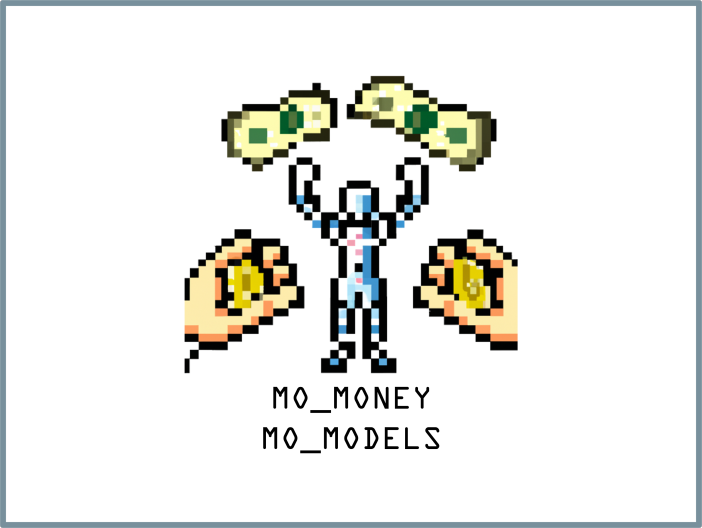
## Team: Mo Money, Mo Models
## 👥 Authors
* David Raposo
* Duarte Pereira
* Martim Chaves
* Paulo Sousa

## 💻 Development
Start coding here! 🐱‍🏍

Create the necessary subsections (e.g. EDA, different experiments, etc..) and markdown cells to include descriptions of your work where you see fit. Comment your code. 

All new subsections must start with three hash characters. More specifically, don't forget to explore the following:
1. Assess the data quality
2. Make sure you have a good EDA where you enlist all the insights
3. Explain the process for feature engineering and cleaning
4. Discuss the model / technique(s) selection
5. Don't forget to explore model interpretability and fairness or justify why it is not needed

Pro-tip 1: Don't forget to make the jury's life easier. Remove any unnecessary prints before submitting the work. Hide any long output cells (from training a model for example). For each subsection, have a quick introduction (justifying what you are about to do) and conclusion (results you got from what you did). 

Pro-tip 2: Have many similiar graphs which all tell the same story? Add them to the appendix and show only a couple of examples, with the mention that all the others are in the appendix.

Pro-tip 3: Don't forget to have a motivate all of your choices, these can be: Data-driven, constraints-driven, literature-driven or a combination of any. For example, why did you choose to test certain algorithms or why only one.

## Introduction
Have you ever found yourself in a crowded area where it's difficult to move around, or perhaps in a situation where there are too many people in one place and it becomes uncomfortable or unsafe? Our CNN-LSTM model for forecasting phone distribution could be the solution you need within the city of Lisbon! The current metro area population of Lisbon in 2023 is 3,001,000, a 0.5% increase from 2022. [1]

Although we encountered some challenges with training time and had to limit the learning rate, epochs, and batch size, we believe this model can have a significant impact on the city of Lisbon. By leveraging the data from phone towers in Lisbon, this model can detect areas with increased people flow and alert city managers, detecting and preventing overcrowding situations before they occur.

We are continually improving this model and plan to add more data sources, such as metro station/route data and climate data, to make it even more accurate and effective. Our goal is to apply this model to other cities and regions around the world, potentially even beyond city planning and management, as it has a wide range of potential applications.

As such, we performed the following tasks:
* 📱 Phone Grid Dataset
    * Exploratory Analysis
    * Cleaning
* ⚙️ Modelling
    * Preliminary Preprocessing
    * CNN-LSTM
* 🚇 Metro Station Dataset - Exploratory Analysis & Proof-of-Concept

### **TODO** 📱 Phone Grid Dataset - Exploratory Analysis and data cleaning
The phone grid dataset constitutes a valuable indicator for people's movement within the city of Lisbon. It contains variables representing phones staying, exiting, and entering grids, as well as which of those are in roaming. 

We performed exploratory analysis and cleaning tasks, including dealing with missing values and outliers.

WARNING: this EDA was not yet applied to the modelling stage due to submission time constraints

### *TODO* ⚙️ Modelling - Preliminary Preprocessing
As we were developing the modells in parallel with the EDA and did not have time to integrate both, here is the preliminary preprocessing pipeline we implemented.


In [ ]:
import numpy as np
import pandas as pd 
import os

import matplotlib.pyplot as plt

Run these to get the gridded data

In [ ]:
# Data file names

grid_info = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "ficheiros_WDL", "DISPOSITIVOS MOVEIS_QUADRICULAS", "DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx")

#There are mov files for different datas, I'll add all of them here latter 
movs_path = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "ficheiros_WDL", "DISPOSITIVOS MOVEIS_GRELHA E EIXOS")
movs_2022_09 = os.path.join(movs_path, "CML_DISPOSITIVOS MOVEIS_GRELHA_indCD15m_2022_09_0001_4000.csv")
movs_2022_10 = os.path.join(movs_path, "CML_DISPOSITIVOS MOVEIS_GRELHA_indCD15m_2022_10_0001_4000.csv")
movs_2022_11 = os.path.join(movs_path, "CML_DISPOSITIVOS MOVEIS_GRELHA_indCD15m_2022_11_0001_4000.csv")


In [ ]:
df_movs_2022_09= pd.read_csv(movs_2022_09)
df_movs_2022_10= pd.read_csv(movs_2022_10)
df_movs_2022_11= pd.read_csv(movs_2022_11)

In [ ]:
#Checking if we can just concatanate the 3 datasets...
print('2022_09 start time: ',df_movs_2022_09['Datetime'].min(),'\n',
'2022_09 end time: ',df_movs_2022_09['Datetime'].max(),'\n',
'2022_10 start time: ',df_movs_2022_10['Datetime'].min(),'\n',
'2022_10 end time: ',df_movs_2022_10['Datetime'].max(),'\n',
'2022_11 start time: ',df_movs_2022_11['Datetime'].min(),'\n',
'2022_11 end time: ',df_movs_2022_11['Datetime'].max())


2022_09 start time:  2022-09-01T00:00:00.000Z 
 2022_09 end time:  2022-09-30T23:45:00.000Z 
 2022_10 start time:  2022-10-01T00:00:00.000Z 
 2022_10 end time:  2022-10-31T23:45:00.000Z 
 2022_11 start time:  2022-11-01T00:00:00.000Z 
 2022_11 end time:  2022-11-30T23:45:00.000Z


In [ ]:
# Join the 3 months' dataframes:

df_movs = pd.concat([df_movs_2022_09, df_movs_2022_10, df_movs_2022_11])
del(df_movs_2022_09, df_movs_2022_10, df_movs_2022_11)

In [ ]:
# Create the 2d grid
dfs_grid = pd.read_excel(grid_info, sheet_name='em bruto', engine='openpyxl')
to_keep = ['latitude', 'longitude', 'grelha_x', 'grelha_y', 'wkt', 'grelha_id']

dfs_grid_filtered = dfs_grid[to_keep]
del(dfs_grid)

# coordinates
lats = dfs_grid_filtered['latitude'].values
lons = dfs_grid_filtered['longitude'].values
# grid indexs
grelha_x = dfs_grid_filtered['grelha_x'].values -1
grelha_y = dfs_grid_filtered['grelha_y'].values -1
grelha_id =  dfs_grid_filtered['grelha_id'].values 

grelha_id_2d = np.empty((grelha_y.max() +1, grelha_x.max()+1))
grelha_id_2d[:] = np.nan
lat_2d = grelha_id_2d.copy()
lon_2d = grelha_id_2d.copy()

# Indices to map from
idx_2d = np.stack([grelha_y, grelha_x])

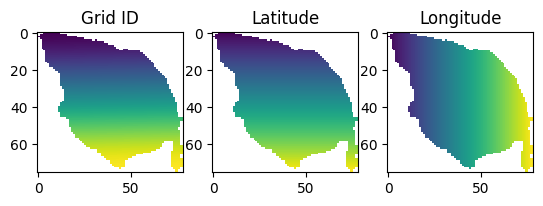

In [ ]:
# Assign the elements to the regular rectangular grid

grelha_id_2d[tuple(idx_2d)] = grelha_id.ravel()
lat_2d[tuple(idx_2d)] = lats.ravel()
lon_2d[tuple(idx_2d)] = lons.ravel()

fig, axs = plt.subplots(1,3)

axs[0].set_title('Grid ID')
axs[0].imshow(grelha_id_2d)

axs[1].set_title('Latitude')
axs[1].imshow(lat_2d, vmax = lats.max(), vmin = lats.min())

axs[2].set_title('Longitude')
axs[2].imshow(lon_2d, vmax = lons.max(), vmin = lons.min())

In [ ]:
dfs_movs = [y for x, y in df_movs.groupby('Grid_ID', as_index=False)]

df_movs['Datetime'] = pd.to_datetime(df_movs['Datetime'])
dfs_movs_ordered = [dfs_movs[i].set_index('Datetime').sort_index() for i in range(len(dfs_movs))]
del(df_movs)
del(dfs_movs)

In [ ]:
# This was to check if each cell id had the same missing timeStamps, since it would allow for a simpler implementation

missing_time_stamps_old = pd.date_range(dfs_movs_ordered[0].index.min(), dfs_movs_ordered[0].index.max(), freq='15min').difference(dfs_movs_ordered[0].index)
for id in range(len(dfs_movs_ordered)):
    missing_time_stamps = pd.date_range(dfs_movs_ordered[id].index.min(), dfs_movs_ordered[id].index.max(), freq='15min').difference(dfs_movs_ordered[id].index)
    same_missing_values = len(missing_time_stamps_old.difference(missing_time_stamps)) == 0 and len(missing_time_stamps_old) == len(missing_time_stamps)
    if not same_missing_values:
        break
    missing_time_stamps_old = missing_time_stamps

In [ ]:

# Function to check if a given dataset has no missing timeStamps

# To use the function, one of the coordinates should be the timeStamp, grid_id and dateTime should not be mixed
# The expected input is a list of dataframes

def fill_dataset(dataset_list, fill_method='nan'):
    """

    Args:
    dataset_list (list):
    fill_method (str): either 'nan' or 'interpolated'
    """

    df_complete = list()

    for dataframe in dfs_movs_ordered:
        missing_time_stamps = pd.date_range(dataframe.index.min(), dataframe.index.max(), freq='15min').difference(dataframe.index)
        missing_values = dataframe.iloc[0:len(missing_time_stamps),:].copy()
        if fill_method in ['nan', 'interpolated']:
            missing_values.loc[:,:] = np.NaN
        else: 
            raise('Invalid Option')
        if fill_method == 'interpolated':
            complete_data = pd.concat([dataframe, missing_values]).sort_index().interpolate(method='linear')
            assert (complete_data == np.NaN).sum().sum() == 0, 'There are still NaN values...'
            df_complete.append(complete_data)
        else:
            df_complete.append(pd.concat([dataframe, missing_values]).sort_index())
    return df_complete

In [ ]:
fill_method = 'interpolated'
df_complete = fill_dataset(dfs_movs_ordered, fill_method='interpolated')
del(dfs_movs_ordered)

In [ ]:
from scipy import stats

# This is to have an undertanding of how many standard deviations should be used
grid_id = 1081
n_stdevs = 10
data = df_complete[grid_id]
statistics = stats.describe(data.iloc[:,1:])
stdev = statistics.variance**0.5
mean = statistics.mean

print(f' Maximum deviation allowed {n_stdevs} standard-deviations: \n{(mean + n_stdevs*stdev)}\n')
print(f' Number of values to remove from each collumn: \n{(data.iloc[:,1:] > (mean + n_stdevs*stdev) ).sum()}')

 Maximum deviation allowed 10 standard-deviations: 
[4847.92841552 1021.89121758 4388.24813074  938.80229782 2087.56393469
 2065.00291621  462.07981746  341.43793538]

 Number of values to remove from each collumn: 
C1    1
C2    0
C3    1
C4    0
C5    3
C6    0
C7    0
C8    0
dtype: int64


Removing non-realistic values

In [ ]:
for element in range(len(df_complete)):
    statistics = stats.describe(df_complete[element])
    stdev = statistics.variance**0.5
    mean = statistics.mean
    values_to_remove = (df_complete[element] > (mean + 10*stdev))
    df_complete[element][values_to_remove] = np.NaN
    df_complete[element] = df_complete[element].sort_index().interpolate(method='linear').ffill().bfill()
    assert np.isnan(df_complete[element]).sum().sum() == 0, f'There are NaN values in element:{element}'

In [ ]:
assert np.isnan(df_complete).sum() == 0, 'There are still NaN values...'

In [ ]:
nTimeStamps = len(df_complete[0].index)
grelha_id_3d = np.repeat(grelha_id_2d[..., np.newaxis], nTimeStamps, axis=-1)
lat_3d = np.repeat(lat_2d[..., np.newaxis], nTimeStamps, axis=-1)
lon_3d = np.repeat(lon_2d[..., np.newaxis], nTimeStamps, axis=-1)

In [ ]:
# Construct the dataset with the right dimensions

nTimeStamps = len(df_complete[0].index)
grelha_id_3d = np.repeat(grelha_id_2d[..., np.newaxis], nTimeStamps, axis=-1)

lat_3d = np.repeat(lat_2d[..., np.newaxis], nTimeStamps, axis=-1)
lon_3d = np.repeat(lon_2d[..., np.newaxis], nTimeStamps, axis=-1)

placeholder = np.full_like(grelha_id_3d, np.NAN)
C1_grid = placeholder
C2_grid = placeholder
C3_grid = placeholder
C4_grid = placeholder
C5_grid = placeholder
C6_grid = placeholder
C7_grid = placeholder
C8_grid = placeholder

In [ ]:
for id in np.unique(grelha_id):
    mask = grelha_id_3d[...,0] == id
    C1_grid[mask] = df_complete[id-1]['C1']
    C2_grid[mask] = df_complete[id-1]['C2']
    C3_grid[mask] = df_complete[id-1]['C3']
    C4_grid[mask] = df_complete[id-1]['C4']
    C5_grid[mask] = df_complete[id-1]['C5']
    C6_grid[mask] = df_complete[id-1]['C6']
    C7_grid[mask] = df_complete[id-1]['C7']
    C8_grid[mask] = df_complete[id-1]['C8']

#del(df_complete)

# Full array of data:
data = np.stack([grelha_id_3d, lat_3d, lon_3d, C1_grid, C2_grid, C3_grid, C4_grid, C5_grid, C6_grid, C7_grid, C8_grid], axis = -1)

(76, 79, 8736, 11)

In [ ]:
grid_path = os.path.join(os.path.dirname(os.getcwd()), "data", "interim", "grid_data.npy")

In [ ]:
# Save data the data array:
# Currently takes 4.6GB
with open(grid_path, 'wb') as f:
    np.save(f, data)

Run this to load the gridded data if already available

In [ ]:
grid_path = os.path.join(os.path.dirname(os.getcwd()), "data", "interim", "grid_data.npy")

# Loading it ...
with open(grid_path, 'rb') as f:
    data = np.load(f)

### **TODO** ⚙️ Modelling - CNN-LSTM

The prpposed CNN-LSTM architecture joins state-of-the-art deep learning models for image processing (CNN, Convolutional Neural Network) and time series forecasting (LSTM, Long Short-Term Memory).

In theory, this model is able to leverage the spatial relationships within the city grid to provide better predictions based on neighbor relations, as well as the temporal dimension for forecasting.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.metrics import mean_squared_error
from scipy import stats
import tensorflow as tf
from tensorflow.keras.layers import TimeDistributed, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, RepeatVector
import pandas as pd
import csv
from datetime import datetime

In [ ]:
grid_path = os.path.join(os.path.dirname(os.getcwd()), "data", "interim", "grid_data.npy")

# Loading it ...
with open(grid_path, 'rb') as f:
    data = np.load(f)

data.shape

(76, 79, 8736, 11)

* Plot a picture of all values

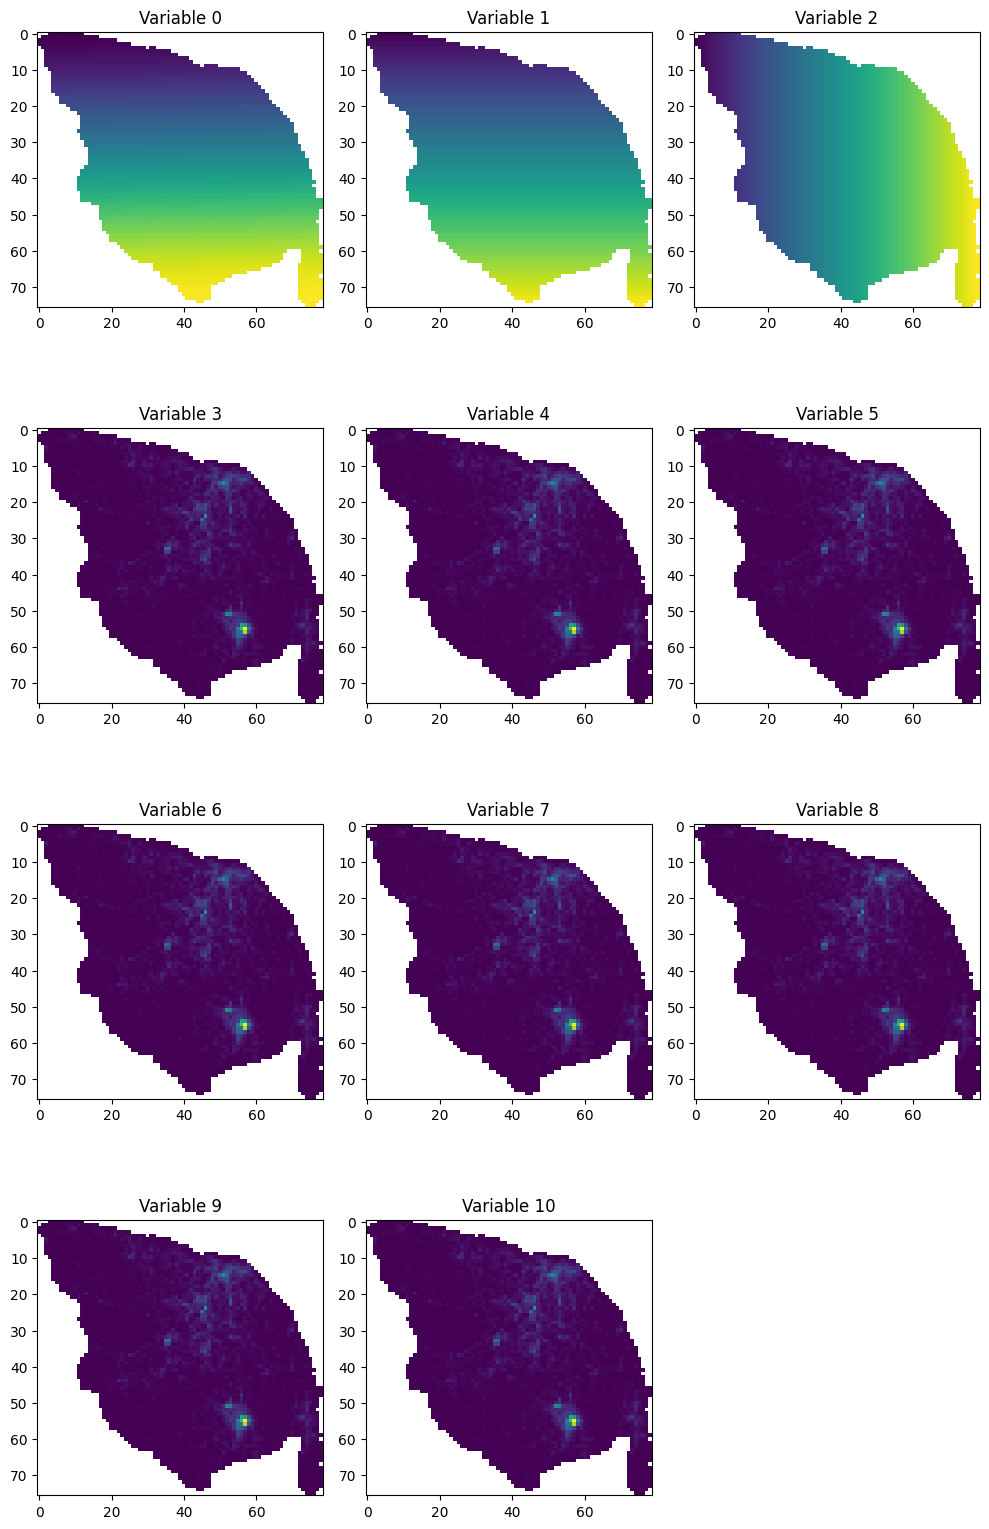

In [ ]:
def plot_picture(grid_data, timestamp_index):
    num_vars = grid_data.shape[-1]
    num_rows = int((num_vars + 2) / 3)
    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(10, 4*num_rows))
    var_list = range(num_vars)
    for var, ax in zip(var_list, axes.flatten()):
        if var < num_vars:
            ax.imshow(grid_data[:,:,timestamp_index,var], interpolation='nearest')
            ax.set_title(f'Variable {var}')
        else:
            ax.axis('off')
    if num_vars % 3 != 0:
        fig.delaxes(axes.flatten()[-1])
    plt.tight_layout()
    plt.show()
    return fig

show_plot = True

if show_plot:
    fig = plot_picture(grid_data = data, timestamp_index = 1000)

Model definition and train

In [ ]:
# The depth of this model can be easily increased
# One could add more Conv layer
# Or increase the units on the LSTM to increase the model capability to fit the training data

# For now the model has only 136,167 parameters

def CNN_LSTM(input_shape, output_shape, forecast_range):
    ## Predicting the value of C1 for all the cells for only 1 timeStamp ahead (may be a waste for grid elements of no interest)
    model = tf.keras.Sequential()
    # define CNN model
    model.add(TimeDistributed(Conv2D(4, (2,2), activation='relu', padding='same', input_shape=input_shape)))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Conv2D(2, (2,2), activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Conv2D(1, (2,2), activation='relu', padding='same')))
    model.add(TimeDistributed(MaxPooling2D(pool_size=(2, 2))))
    model.add(TimeDistributed(Flatten()))
    model.add(LSTM(units=100))
    model.add(RepeatVector(forecast_range))
    model.add(LSTM(units=100, return_sequences= True))
    model.add(TimeDistributed(Dense(output_shape)))

    model.build(input_shape) # input_shape is the shape of the input data
    model.summary()

    return model

In [ ]:
N_IN_24_H = 24*4
FORECAST_RANGE = 4 # 1 hour

In [ ]:
def windowed_dataset(data, relevant_cells_mask, window_size, batch_size, shift, forecast_range):
    """
    """

    dataset = tf.data.Dataset.from_tensor_slices(data)
    dataset = dataset.window(window_size, shift=shift, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size))
    dataset = dataset.map(lambda window: (window[:-forecast_range], tf.stack([window[-i,:,:,0][relevant_cells_mask] for i in range(forecast_range)])))

    dataset = dataset.batch(batch_size).prefetch(1)

    return dataset


In [ ]:
def ingestion(data, window_size, shift, batch_size, forecast_range):
    cell_ids = data[...,0,0]
    relevant_cells_mask = ~np.isnan(cell_ids)
    output_shape = relevant_cells_mask.sum()

    # Setting the timestep dim as the first dimensions
    data = np.transpose(data, (2, 0, 1, 3))
    print(f'Whole dataset shape: {data.shape}')

    # Using only the C's data
    x_data = data[...,3:]
    x_data[np.isnan(x_data)] = 0
    # Train/val split
    # Val and test data are split from training data, and correspond to the last month, ~2 weeks each. Cross-validation can be a valuable alternative for a future iteration.
    x_data_train = x_data[:int(x_data.shape[0]*2/3),...] 
    x_data_val = x_data[int(x_data.shape[0]*2/3):int(x_data.shape[0]*(2/3 + 1/6)),...]
    x_data_test = x_data[int(x_data.shape[0]*(2/3 + 1/6)):,...]

    train_dataset = windowed_dataset(x_data_train, relevant_cells_mask, window_size, batch_size, shift, forecast_range)
    validation_dataset = windowed_dataset(x_data_val, relevant_cells_mask, window_size, batch_size, shift, forecast_range)
    test_dataset = windowed_dataset(x_data_test, relevant_cells_mask, window_size, batch_size, shift, forecast_range)

    return train_dataset, validation_dataset, test_dataset, output_shape

In [ ]:
# This function keeps the initial learning rate for the first ten epochs
# and decreases it exponentially after that. - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler
def scheduler(epoch, lr):
  if epoch < 10:
    return lr
  else:
    return lr * tf.math.exp(-0.05)

def train(train_dataset, validation_dataset, input_shape, output_shape, forecast_range, lr, epochs, vis):

    model = CNN_LSTM(input_shape, output_shape, forecast_range)
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
    loss = tf.keras.losses.MeanSquaredError()
    model.compile(optimizer=optimizer, loss=loss)
    # the patience parameter is the number of epochs with no improvement after which training will be stopped.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
    lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

    history = model.fit(train_dataset, validation_data=validation_dataset, epochs=epochs, callbacks=[early_stopping, lr_scheduler])

    # summarize history for loss
    if vis:
        # list all data in history
        print(history.history.keys())

        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

    return model, history.history['loss'], history.history['val_loss']

* Run experiment

In [ ]:
def experiment(data, window_size = N_IN_24_H+FORECAST_RANGE, shift = 4, batch_size=32, lr=5e-3, epochs=100, vis=False, model_path='model.h5', forecast_range=4):
    # Ingestion
    train_dataset, validation_dataset, test_dataset, output_shape = ingestion(data, window_size, shift, batch_size, forecast_range)
    input_shape = (None,96,76,79,8)

    # Train
    model, train_loss, val_loss = train(train_dataset, validation_dataset, input_shape, output_shape, forecast_range, lr, epochs, vis)
    model.save(model_path)

    ## We don't need this anymore, the fit method will take care of that for us
    # # Model prediction
    # relevant_cells_mask = ~np.isnan(data[...,0,0])
    # ground_truth = x_data_val_and_test[N_IN_24_H,...,0][relevant_cells_mask]
    # pred, mse = predict_evaluate(model, x_data_val_and_test, ground_truth)

    return model, train_loss, val_loss, test_dataset

To run single experiment:
`model, train_loss, val_loss = experiment(data, window_size = N_IN_24_H+FORECAST_RANGE, shift = 4, batch_size=32, lr=1e-2, vis=True, model_path='model.h5')`

* Iterate over multiple window_sizes

In [ ]:
header = ['timestamp', 'window', 'forecast_range', 'train_loss', 'val_loss']

In [ ]:
# fast

# create a CSV file and open it in write mode
with open(os.path.join(os.path.dirname(os.getcwd()), 'reports', 'iteration_results_fast.csv'), mode='w', newline='') as file:

    writer = csv.writer(file)
    model_fn_list = ['24h_1h', '24h_12h', '48h_1h', '48h_12h', '48_24h', '96h_1h', '96h_12h', '96h_24h']
    # You may be able to increase these if your machine has more that 20 GiB of RAM
    batch_size_list = [32, 32, 16, 16, 16, 8, 8, 8, 8]
    FORECAST_RANGE_list = [4, 12*4, 4, 12*4, 24*4, 4, 12*4, 24*4]

    # The shift parameter is currently set to 1 (shift of 15 min) to use all the available data
    # The number of epochs is 200 but can be increased, but the callback may stop it sooner
    # The lr of 5e-3 might be hight but I think that lr = 1e-3 could make it slow

    writer.writerow(header)
    for i, window in enumerate([N_IN_24_H, N_IN_24_H, N_IN_24_H*2, N_IN_24_H*2, N_IN_24_H*2, N_IN_24_H*4, N_IN_24_H*4, N_IN_24_H*4]):
        _, train_loss, val_loss, _ = experiment(data, window_size = window+FORECAST_RANGE_list[i], shift = 25, batch_size=batch_size_list[i], lr=3e-3, epochs=60, vis=True, model_path = f'models/model{model_fn_list[i]}.h5', forecast_range= FORECAST_RANGE_list[i])
        timestamp = datetime.now().strftime("%Y-%m-%d %H:%M:%S") # get current timestamp
        row = [timestamp, window, FORECAST_RANGE_list[i], train_loss, val_loss]
        print('FINISH: ', row)
        writer.writerow(row)

From this, we can evaluate different possibilities for training the model, regarding

* Using a trained model to perform predictions

Here we can either train a new model, or simply import one already trained.

In [ ]:
# Training a new model
window_size = N_IN_24_H + FORECAST_RANGE
FORECAST_RANGE = 4
shift = 24

model, train_loss, val_loss, test_dataset = experiment(data, window_size = window_size, shift = shift, batch_size=32, lr=5e-3, epochs=3, vis=True, model_path = f'models/model.h5', forecast_range= FORECAST_RANGE)
train_dataset, validation_dataset, test_dataset, output_shape = ingestion(data, window_size, shift=shift, batch_size=1, forecast_range=FORECAST_RANGE)

In [ ]:
# Loading a previously trained model
# Here it is important to ensure that the test_dataset is using the same window_size and forecast_range as you used to train your model

window_size = N_IN_24_H + FORECAST_RANGE
FORECAST_RANGE = 4
shift = 4

train_dataset, validation_dataset, test_dataset, output_shape = ingestion(data, window_size, shift=shift, batch_size=32, forecast_range=FORECAST_RANGE)
model = tf.keras.models.load_model('models/model.h5')

Next we predict on the whole test dataset. We evaluate the MSE there and save all the predictions

In [ ]:
def predict_evaluate(model, x_test, y_test):
    pred = model(x_test).numpy()
    mse = np.mean((y_test - pred)**2)
    return pred, mse

mse_list = []
pred_list = []
y_true_list = []

for x,y in test_dataset:
    pred, mse = predict_evaluate(model, x, y)
    mse_list.append(mse)
    pred_list.append(pred)
    y_true_list.append(y.numpy())
    
predictions = np.stack(pred_list[:-1])
ys = np.stack(y_true_list[:-1])

# Do not use the last mse value, it may be from a batch different than the batch size
# This happens if the total number of samples is not divisible by the batch size
MSE = np.mean(mse_list[:-1])
print(f'MSE for the test data: {MSE}')

Next we plot some predictions and compare it to our ground truth.

In [ ]:
# Function to convert the 1D prediction into a 2D image
def pred_into_grid(pred, ground_truth):

    grid_info = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "ficheiros_WDL", "DISPOSITIVOS MOVEIS_QUADRICULAS", "DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx")
    dfs_grid = pd.read_excel(grid_info, sheet_name='em bruto', engine='openpyxl')

    # grid indexes
    grelha_x = dfs_grid['grelha_x'].values -1
    grelha_y = dfs_grid['grelha_y'].values -1
    grelha_id =  dfs_grid['grelha_id'].values 

    grelha_id_2d = np.empty((grelha_y.max() +1, grelha_x.max()+1))
    grelha_id_2d[:] = np.nan
    pred_2d = grelha_id_2d.copy()
    ground_truth_2d = grelha_id_2d.copy()

    # Indices to map from
    idx_2d = np.stack([grelha_y, grelha_x])

    # Assign the elements to the regular rectangular grid
    pred_2d[tuple(idx_2d)] = pred.ravel()
    ground_truth_2d[tuple(idx_2d)] = ground_truth.ravel()

    return pred_2d, ground_truth_2d

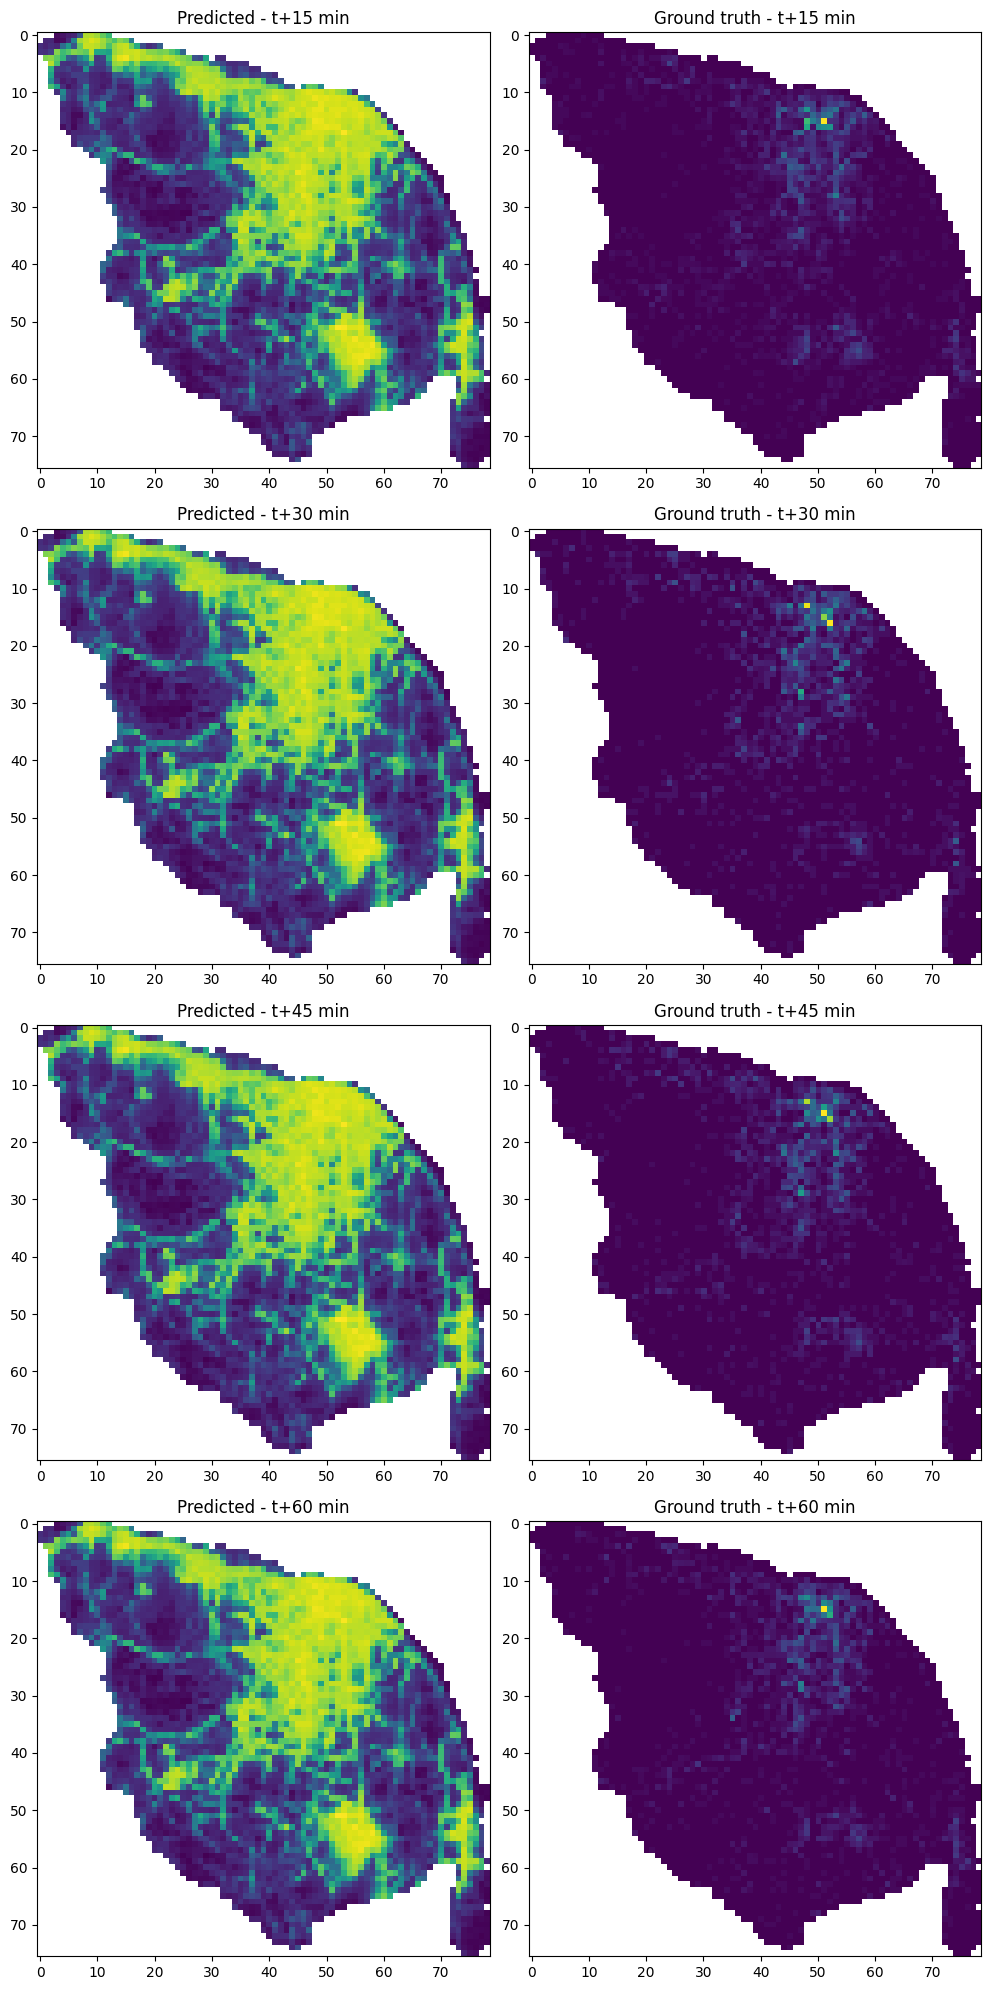

In [ ]:
example_pred  = predictions[0,0]
example_truth = ys[0,0]

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(10, 20))

for time in range(4):
    # Define some pred and ground truth here 
    pred_2d, ground_truth_2d = pred_into_grid(example_pred[time], example_truth[time])

    axs[time,0].set_title(f'Predicted - t+{15*(time+1)} min')
    axs[time,0].imshow(pred_2d)

    axs[time,1].set_title(f'Ground truth - t+{15*(time+1)} min')
    axs[time,1].imshow(ground_truth_2d)
plt.tight_layout()
plt.show()

In [ ]:
truth_stats = stats.describe(predictions.flatten())
pred_stats = stats.describe(ys.flatten())

print("RESULTS")
print("MSE:", MSE)
print("Ground Truth Stats:", truth_stats)
print("Predictions Stats: ", pred_stats)

RESULTS
MSE: 807.0118738145511
Ground Truth Stats: DescribeResult(nobs=4791040, minmax=(-0.14972183, 11.438719), mean=4.115102, variance=12.388175689029088, skewness=0.5816687875475826, kurtosis=-1.2019993077544802)
Predictions Stats:  DescribeResult(nobs=4791040, minmax=(0.0, 1107.0799560546875), mean=10.704583719830191, variance=841.7510284597387, skewness=9.053568265229877, kurtosis=140.18455767858933)


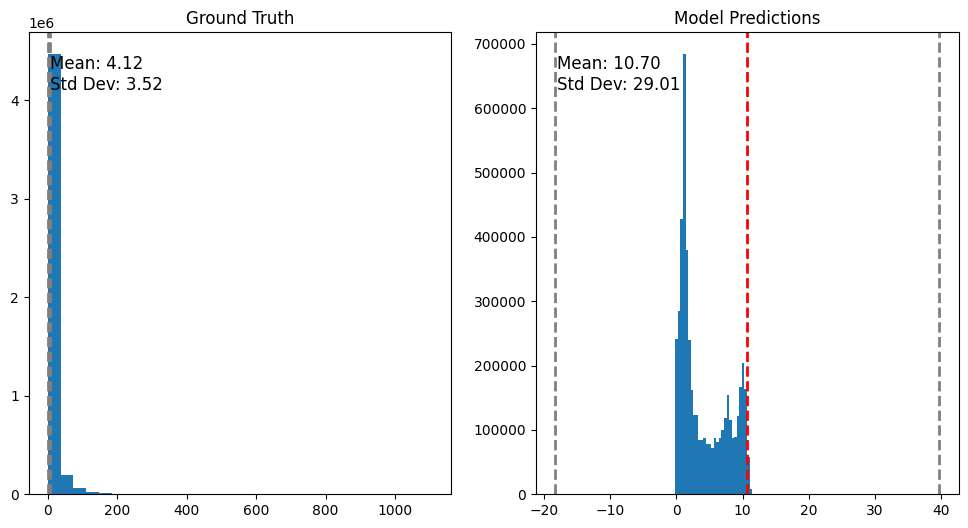

In [ ]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6))

ax1.hist(ys.flatten(), bins=30)
ax1.set_title('Ground Truth')
ax1.axvline(truth_stats.mean, color='red', linestyle='dashed', linewidth=2)
ax1.axvline(truth_stats.mean - truth_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax1.axvline(truth_stats.mean + truth_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax1.text(0.05, 0.95, f"Mean: {truth_stats.mean:.2f}\nStd Dev: {truth_stats.variance**0.5:.2f}", transform=ax1.transAxes, fontsize=12, verticalalignment='top')

ax2.hist(predictions.flatten(), bins=30)
ax2.set_title('Model Predictions')
ax2.axvline(pred_stats.mean, color='red', linestyle='dashed', linewidth=2)
ax2.axvline(pred_stats.mean - pred_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax2.axvline(pred_stats.mean + pred_stats.variance**0.5, color='gray', linestyle='dashed', linewidth=2)
ax2.text(0.05, 0.95, f"Mean: {pred_stats.mean:.2f}\nStd Dev: {pred_stats.variance**0.5:.2f}", transform=ax2.transAxes, fontsize=12, verticalalignment='top')

plt.show()

### **TODO** ⚙️Modelling - Performance Evaluation

### **TODO** 🚇 Metro Station Dataset - Exploratory Analysis & Proof-of-Concept
In addition to the phone grid data, we intend to add metro station/route data and climate data, such as temperature and precipitation, in future implementations. 

We developed a proof-of-concept for the metro station dataset, which involves transforming the data to concatenate with the phone grid and have the same resolution as the grid (200 x 200 meter units).

In [ ]:
import os
import folium
import geopandas as gpd
import pandas as pd
import json
import numpy as np
from shapely import wkt


In [ ]:
# Read data from the xlsx file
grid_info = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "ficheiros_WDL", "DISPOSITIVOS MOVEIS_QUADRICULAS", "DISPOSITIVOS MOVEIS_QUADRICULAS.xlsx")
data = pd.read_excel(grid_info, sheet_name='em bruto', engine='openpyxl')

In [ ]:
data.head()

,grelha_id,dicofre,entity_id,entity_type,freguesia,freguesias,grelha_x,grelha_y,latitude,longitude,nome,objectid,position,wkt
0,1,110658,coi.tematica.grelha.lx.atributos.3518,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,4,1,38.692094,-9.225027,Área ribeirinha Pedrouços,1,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON {{{-9.22412591616028 38.691391736...
1,2,110658,coi.tematica.grelha.lx.atributos.3519,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,5,1,38.692094,-9.223231,Área ribeirinha Pedrouços,2,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON {{{-9.22232928559204 38.691391736...
2,3,110658,coi.tematica.grelha.lx.atributos.3520,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,6,1,38.692094,-9.221434,Área ribeirinha Pedrouços,3,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON {{{-9.2205326550238 38.6913917367...
3,4,110658,coi.tematica.grelha.lx.atributos.3521,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,7,1,38.692094,-9.219637,Torre de Belém,4,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON {{{-9.21873602445556 38.691391736...
4,5,110658,coi.tematica.grelha.lx.atributos.3522,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,8,1,38.692094,-9.217841,Torre de Belém,5,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON {{{-9.21693939388732 38.691391736...


In [ ]:
# Extract ids
ids = data["grelha_id"].tolist()

In [ ]:
# Function to remove extra curly braces and return a valid WKT string
def fix_wkt_string(wkt_string):
    return wkt_string.replace("{{{", "(((").replace("}}}", ")))")

In [ ]:
# Remove extra curly braces
data["wkt"] = data["wkt"].apply(fix_wkt_string)

In [ ]:
# Apply wkt.loads
polygons = data["wkt"].apply(wkt.loads).tolist()

In [ ]:
# Create a GeoDataFrame from the polygons
gdf = gpd.GeoDataFrame({"id": ids, "geometry": polygons})

In [ ]:
# Calculate the center of the map (average latitude and longitude)
center_lat = gdf.geometry.centroid.y.mean()
center_lon = gdf.geometry.centroid.x.mean()

In [ ]:
# Create a folium map
m = folium.Map(location=[center_lat, center_lon], zoom_start=14)

In [ ]:
# Add grid squares to the map
for _, row in gdf.iterrows():
    folium.GeoJson(row.geometry, tooltip=f"ID: {row.id}").add_to(m)

In [ ]:
# Save the map to an HTML file
m.save("grid_map.html")

* Add Estações_de_Comboio to data:

In [ ]:
new_data = data.copy()
if 'nome_estacao' not in new_data:
    list(new_data.columns.values)
    new_data.insert(loc = len(new_data.columns),
            column = 'nome_estacao',
            value = " ")
    
if 'linha' not in new_data:
    new_data.insert(loc = len(new_data.columns),
            column = 'linha',
            value = 0)

In [ ]:
# Target value
target = [-9.14609167401547, 38.7062703226346]

# Calculate squared Euclidean distances
aux = new_data.copy()
aux['distance'] = np.sqrt((new_data['longitude'] - target[0])**2 + (new_data['latitude'] - target[1])**2)

# Sort by distances
data_sorted = aux.sort_values('distance')

# Get row with smallest distance
closest_row = data_sorted.iloc[0, :]


In [ ]:
# Specify the file path to GeoJSON data
file_path = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "redes", "Estações_de_Comboio.geojson")

# Read the file and load the data
with open(file_path, "r") as f:
    geojson_data = json.load(f)
    
line_color_dict = {}  # Dictionary to store line color mapping
features = geojson_data["features"]

for feature in features:
    coordinates = feature["geometry"]["coordinates"]
    nome = feature["properties"]["NOME"]
    objectid = feature["properties"]["OBJECTID"]
    linha = feature["properties"]["LINHA"]
    
    # Assign unique ID for different "LINHA" values
    if linha not in line_color_dict:
        line_color_dict[linha] = len(line_color_dict) + 1
    
    # Target value
    target = coordinates

    # Calculate squared Euclidean distances
    aux = new_data.copy()
    aux['distance'] = np.sqrt((new_data['longitude'] - target[0])**2 + (new_data['latitude'] - target[1])**2)

    # Sort by distances
    data_sorted = aux.sort_values('distance')

    # Get row with smallest distance
    closest_row = data_sorted.iloc[0, :]

    new_data.loc[new_data['grelha_id'] == closest_row['grelha_id'], 'linha'] = line_color_dict[linha]
    new_data.loc[new_data['grelha_id'] == closest_row['grelha_id'], 'nome_estacao'] = nome
    


In [ ]:
new_data.head()


,grelha_id,dicofre,entity_id,entity_type,freguesia,freguesias,grelha_x,grelha_y,latitude,longitude,nome,objectid,position,wkt,nome_estacao,linha
0,1,110658,coi.tematica.grelha.lx.atributos.3518,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,4,1,38.692094,-9.225027,Área ribeirinha Pedrouços,1,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON (((-9.22412591616028 38.691391736...,,0
1,2,110658,coi.tematica.grelha.lx.atributos.3519,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,5,1,38.692094,-9.223231,Área ribeirinha Pedrouços,2,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON (((-9.22232928559204 38.691391736...,,0
2,3,110658,coi.tematica.grelha.lx.atributos.3520,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,6,1,38.692094,-9.221434,Área ribeirinha Pedrouços,3,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON (((-9.2205326550238 38.6913917367...,,0
3,4,110658,coi.tematica.grelha.lx.atributos.3521,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,7,1,38.692094,-9.219637,Torre de Belém,4,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON (((-9.21873602445556 38.691391736...,,0
4,5,110658,coi.tematica.grelha.lx.atributos.3522,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,8,1,38.692094,-9.217841,Torre de Belém,5,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON (((-9.21693939388732 38.691391736...,,0


In [ ]:

column_elements = new_data['linha'].unique().tolist()
print(column_elements)

linha_counts = new_data['linha'].value_counts()
print(linha_counts)

column_elements = new_data['nome_estacao'].unique().tolist()
print(column_elements)

linha_counts = new_data['nome_estacao'].value_counts()
print(linha_counts)

print("Dictionary Train Lines")
print(line_color_dict)


[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
0     3694
2       15
1       10
4        9
9        9
3        1
5        1
6        1
7        1
8        1
10       1
Name: linha, dtype: int64
[' ', 'Cais do Sodré', 'Terreiro do Paço', 'Baixa Chiado', 'Rossio', 'Santa Apolónia', 'Restauradores', 'Martim Moniz', 'Rato', 'Avenida', 'Intendente', 'Marquês de Pombal', 'Anjos', 'Parque', 'Picoas', 'Arroios', 'São Sebastião', 'Saldanha', 'Alameda', 'Praça de Espanha', 'Olaias', 'Jardim Zoológico', 'Campo Pequeno', 'Areeiro', 'Entre Campos', 'Laranjeiras', 'Roma', 'Bela Vista', 'Alto dos Moinhos', 'Cidade Universitária', 'Reboleira', 'Colégio Militar', 'Alvalade', 'Chelas', 'Amadora Este', 'Alfornelos', 'Carnide', 'Telheiras', 'Campo Grande', 'Olivais', 'Pontinha', 'Cabo Ruivo', 'Quinta das Conchas', 'Aeroporto', 'Oriente', 'Lumiar', 'Encarnação', 'Moscavide', 'Ameixoeira', 'Odivelas']
                        3694
Telheiras                  1
Bela Vista                 1
Alto dos Moinhos           1
Cid

In [ ]:
ids = new_data["grelha_id"].tolist()

def fix_wkt_string(wkt_string):
    return wkt_string.replace("{{{", "(((").replace("}}}", ")))")

new_data["wkt"] = new_data["wkt"].apply(fix_wkt_string)

polygons = new_data["wkt"].apply(wkt.loads).tolist()

# Convert linha column to integer to ensure correct color mapping
new_data['linha'] = new_data['linha'].astype(int)

gdf = gpd.GeoDataFrame({"id": ids, "geometry": polygons, "linha": new_data['linha'], "nome_estacao": new_data['nome_estacao']})

# Define color mapping based on linha column values
color_map_original = line_color_dict
print("color_map_original: " )
print(color_map_original)

# Swap the keys and values in the color mapping dictionary
color_map_swapped = {v: k for k, v in color_map_original.items()}
print("color_map_swapped: " )
print(color_map_swapped)

# Define a dictionary that maps linha values to colors
color_map = {1: 'lime', 2: 'blue', 3: 'cyan', 4: 'yellow', 5: 'green', 6: 'purple', 7: 'orange', 8: 'brown', 9: 'red', 10: 'olive'}
print("color_map: " )
print(color_map)

# Update the GeoDataFrame with the swapped color mapping
gdf['linha'] = gdf['linha'].map(color_map_swapped)


center_lat = gdf.geometry.centroid.y.mean()
center_lon = gdf.geometry.centroid.x.mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=14)

# Set the CRS of gdf
gdf = gdf.set_crs("EPSG:4326")  # Replace "EPSG:4326" with the appropriate CRS for your data

# Function to style each feature
def style_function(feature):
    linha = feature['properties']['linha']
    if (linha==None):
        num_linha=0
    else:
        num_linha=color_map_original[linha]
    color = color_map.get(num_linha, 'gray')  # Use gray as default color for unknown values
    return {'fillColor': color, 'color': 'black', 'weight': 1, 'fillOpacity': 0.6}

# Add GeoJson layer to the map with style_function applied
folium.GeoJson(gdf, style_function=style_function, tooltip=folium.features.GeoJsonTooltip(fields=['id', 'nome_estacao'], aliases=['ID', 'Estação'])).add_to(m)

m.save("grid_map_station.html")


color_map_original: 
{'Verde': 1, 'Azul': 2, 'Azul/Verde': 3, 'Amarela': 4, 'Azul/Amarela': 5, 'Azul/Vermelha': 6, 'Amarela/Vermelha': 7, 'Verde/Vermelha': 8, 'Vermelha': 9, 'Amarela/Verde': 10}
color_map_swapped: 
{1: 'Verde', 2: 'Azul', 3: 'Azul/Verde', 4: 'Amarela', 5: 'Azul/Amarela', 6: 'Azul/Vermelha', 7: 'Amarela/Vermelha', 8: 'Verde/Vermelha', 9: 'Vermelha', 10: 'Amarela/Verde'}
color_map: 
{1: 'lime', 2: 'blue', 3: 'cyan', 4: 'yellow', 5: 'green', 6: 'purple', 7: 'orange', 8: 'brown', 9: 'red', 10: 'olive'}


# Add Rede_Ferroviária to data:

In [ ]:
new_data_rede = data.copy()
if 'nome_linha' not in new_data_rede:
    list(new_data_rede.columns.values)
    new_data_rede.insert(loc = len(new_data_rede.columns),
            column = 'nome_linha',
            value = " ")
    
if 'segmentos_linha' not in new_data_rede:
    new_data_rede.insert(loc = len(new_data_rede.columns),
            column = 'segmentos_linha',
            value = " ")

In [ ]:
# Specify the file path to GeoJSON data
file_path = os.path.join(os.path.dirname(os.getcwd()), "data", "raw", "redes", "Rede_Ferroviária.geojson")

# Read the file and load the data
with open(file_path, "r") as f:
    geojson_ferrovias = json.load(f)
    
linhas_dict = {}  # Dictionary to store line color mapping
features = geojson_ferrovias["features"]

for feature in features:
    coordinates = feature["geometry"]["coordinates"]
    nome = feature["properties"]["NOME"]
    objectid = feature["properties"]["OBJECTID"]
    linha = feature["properties"]["DESIG_SEGM"]
    
    # Assign unique ID for different "LINHA" values
    if linha not in linhas_dict:
        linhas_dict[linha] = len(linhas_dict) + 1
    
    # Target value
    #target = coordinates
    for target in coordinates:
        # Calculate squared Euclidean distances
        aux = new_data_rede.copy()
        aux['distance'] = np.sqrt((new_data_rede['longitude'] - target[0])**2 + (new_data_rede['latitude'] - target[1])**2)

        # Sort by distances
        data_sorted = aux.sort_values('distance')

        # Get row with smallest distance
        closest_row = data_sorted.iloc[0, :]

        new_data_rede.loc[new_data_rede['grelha_id'] == closest_row['grelha_id'], 'nome_linha'] = nome
        new_data_rede.loc[new_data_rede['grelha_id'] == closest_row['grelha_id'], 'segmentos_linha'] = linhas_dict[linha]
    

In [ ]:
new_data_rede.head()

,grelha_id,dicofre,entity_id,entity_type,freguesia,freguesias,grelha_x,grelha_y,latitude,longitude,nome,objectid,position,wkt,nome_linha,segmentos_linha
0,1,110658,coi.tematica.grelha.lx.atributos.3518,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,4,1,38.692094,-9.225027,Área ribeirinha Pedrouços,1,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON (((-9.22412591616028 38.691391736...,,
1,2,110658,coi.tematica.grelha.lx.atributos.3519,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,5,1,38.692094,-9.223231,Área ribeirinha Pedrouços,2,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON (((-9.22232928559204 38.691391736...,,
2,3,110658,coi.tematica.grelha.lx.atributos.3520,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,6,1,38.692094,-9.221434,Área ribeirinha Pedrouços,3,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON (((-9.2205326550238 38.6913917367...,,
3,4,110658,coi.tematica.grelha.lx.atributos.3521,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,7,1,38.692094,-9.219637,Torre de Belém,4,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON (((-9.21873602445556 38.691391736...,,
4,5,110658,coi.tematica.grelha.lx.atributos.3522,coi.tematica.grelha.lx.atributos,Belém,Santa Maria de Belém + São Francisco Xavier,8,1,38.692094,-9.217841,Torre de Belém,5,"{'type': 'GeometryCollection', 'geometries': [...",MULTIPOLYGON (((-9.21693939388732 38.691391736...,,


In [ ]:

column_elements = new_data_rede['nome_linha'].unique().tolist()
print(column_elements)

linha_counts = new_data_rede['nome_linha'].value_counts()
print(linha_counts)

column_elements = new_data_rede['segmentos_linha'].unique().tolist()
print(column_elements)

linha_counts = new_data_rede['segmentos_linha'].value_counts()
print(linha_counts)

print("Dictionary Train Lines")
print(linhas_dict)

[' ', 'Linha de Cascais', 'Linha do Sul', 'Linha de Cintura', 'Linha do Norte', 'Linha de Sintra', 'Linha da Matinha', 'Concordância de Sete Rios']
                             3434
Linha de Cintura               78
Linha do Norte                 75
Linha de Sintra                61
Linha de Cascais               58
Linha do Sul                   19
Linha da Matinha               17
Concordância de Sete Rios       1
Name: nome_linha, dtype: int64
[' ', 6, 1, 2, 4, 9, 7, 5, 3, 8]
     3434
4      74
7      61
9      60
6      58
1      19
5      17
8      15
2       4
3       1
Name: segmentos_linha, dtype: int64
Dictionary Train Lines
{'Agulha junto à Ponte Santana / Pinhal Novo': 1, 'Alcântara Mar / Alcântara Terra': 2, 'Sete Rios / Benfica': 3, 'Alcântara Terra / Braço de Prata': 4, 'Lisboa Santa Apolónia / Lisboa-Matinha': 5, 'Cais do Sodré / Cascais': 6, 'Lisboa Rossio / Sintra': 7, 'Lisboa Santa Apolónia / Porto Campanhã/ Parque Nações/ Loures': 8, 'Lisboa Santa Apolónia / Porto C

### TODO - Conclusion

Future Work:
* Apply EDA cleaned data in the modelling stage
* Add transports and climate datasets to modelling and compare performance with benchmark
* Cross-validation
* Run on less limited time constraints and with GPU processing
* Increase the number of layers
* Encode time-of-day and day-of-week information (handle rush hours and weekend/workdays)

## 🖼️ Visualisations
Copy here the most important visualizations (graphs, charts, maps, images, etc). You can refer to them in the Executive Summary.

Technical note: If not all the visualisations are visible, you can still include them as an image or link - in this case please upload them to your own repository.

### TODO 📱 Phone Grid Dataset - Exploratory Data Analysis

### **TODO** ⚙️Modelling - Performance

### **TODO** 🚇 Metro Station Dataset - Exploratory Analysis

## 👓 References
List all of the external links (even if they are already linked above), such as external datasets, papers, blog posts, code repositories and any other materials.

[1] city of Lisbon population in 2023 - https://www.macrotrends.net/cities/22167/lisbon/population#:~:text=The%20current%20metro%20area%20population,a%200.51%25%20increase%20from%202020. - last accessed 18/04/2023

[2] CNN-LSTM model - https://github.com/Pradnya1208/Time-series-forecasting-using-Deep-Learning  - last accessed 18/04/2023

[3] learning rate scheduler - https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/LearningRateScheduler  - last accessed 18/04/2023


## ⏭️ Appendix
Add here any code, images or text that you still find relevant, but that was too long to include in the main report. This section is optional.
